In [56]:
import sys
import yfinance as yf
import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import ParameterSampler
from joblib import Parallel, delayed
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.vecm import VECM
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

In [31]:
import warnings
warnings.filterwarnings("ignore", message=".*no associated frequency information.*")

In [3]:
def download_prices(tickers, start="2015-01-01"):
    df = yf.download(tickers, start=start, auto_adjust=True, progress=False)[['Close']]
    df.dropna(inplace=True)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(1)
    return df

In [4]:
def rolling_zscore(series, thr_window):
    m = series.rolling(thr_window).mean()
    s = series.rolling(thr_window).std(ddof=1)
    return (series - m) / s

In [65]:
def estimate_half_life(spread):
    spread = spread.dropna()
    lagged = spread.shift(1).dropna()
    delta = spread.diff().dropna()
    df = pd.DataFrame({'y': delta, 'x': lagged.loc[delta.index]})
    beta = np.linalg.lstsq(df['x'].values.reshape(-1, 1), df['y'].values, rcond=None)[0][0]
    halflife = -np.log(2) / beta
    return max(1, round(halflife))

In [5]:
def generate_signal(z, long_z, short_z):
    sig, state = pd.Series(0, index=z.index), 0
    prev = z.shift(1)
    for t in z.index:
        c, p = z.at[t], prev.at[t]
        if pd.notna(c) and pd.notna(p):
            if state == 0 and p >= long_z and c < long_z:
                state = 1  # Enter Long
            elif state == 0 and p <= short_z and c > short_z:
                state = -1  # Enter Short
            elif state == 1 and c < short_z and c >= 0:
                state = 0  # Exit Long only
            elif state == 1 and c > short_z:
                state = -1  # Exit Long and Flip to Short
            elif state == -1 and c > long_z and c <= 0:
                state = 1  # Exit Short and enter long
            elif state == 1 and c <= 0:
                state = 0
        sig.at[t] = state
    return sig.astype(int)

In [9]:
def backtest_alpha_scaled_basket(df, beta, signal, fee_per_trade=0.001):
    """
    df     : DataFrame with cointegrated assets (e.g., ['SPY','QQQ','XLK'])
    beta   : vecm_res.beta[:, 0] → cointegration vector (np.array)
    signal : pd.Series of +1 / -1 / 0 for long/short/flat on the spread basket
    """
    basket_ret = df.pct_change().dropna() @ beta

    # Align signal
    signal = signal.reindex(df.index).fillna(0).astype(int)
    pos = signal.shift(1).reindex(basket_ret.index).fillna(0).astype(int)
    strat_ret = pos * basket_ret

    # Apply fees
    abs_sum = np.sum(np.abs(beta))
    per_trade_cost = fee_per_trade * abs_sum  # like slippage × turnover per rebalance
    entries = (pos.shift(1) != pos) & (pos != 0)
    strat_ret.loc[entries] -= per_trade_cost

    # Metrics
    equity = (1+strat_ret).cumprod()
    days = len(basket_ret)
    total = equity.iloc[-1] - 1
    cagr     = equity.iloc[-1]**(252/days) - 1
    ann_vol  = strat_ret.std(ddof=1) * np.sqrt(252)
    sharpe   = (strat_ret.mean() / strat_ret.std() * np.sqrt(252)) if strat_ret.std() != 0 else np.nan
    max_dd   = (equity / equity.cummax() - 1).min()
    nz       = strat_ret[strat_ret != 0]
    hit_rate = (nz > 0).sum() / len(nz) if len(nz) else np.nan

    # Hold durations
    changes = pos != pos.shift(1)
    dates   = pos.index[changes]
    vals    = pos[changes]
    hold, prev, ent = [], 0, None
    for d, v in zip(dates, vals):
        if v != 0 and prev == 0:
            ent = d
        if v == 0 and prev != 0 and ent is not None:
            hold.append((d - ent).days)
            ent = None
        prev = v
    if prev != 0 and ent is not None:
        hold.append((pos.index[-1] - ent).days)
    avg_hold = np.mean(hold) if hold else np.nan

    return {
        'Total Return':  total,
        'CAGR':          cagr,
        'Ann Vol':       ann_vol,
        'Sharpe':        sharpe,
        'Max Drawdown':  max_dd,
        'Trades':        int(entries.sum()),
        'Hit Rate':      hit_rate,
        'Avg Hold Days': avg_hold,
        'Data Points':   days
    }

In [73]:
def get_coint_params(df, det_order=1, k_ar_diff=2):
  model = VECM(df, k_ar_diff=2, coint_rank=1, deterministic='co')  # 'co' for NONE constant in cointegration eq
  vecm_res = model.fit()
  beta = vecm_res.beta
  alpha = vecm_res.alpha
  spread = df @ vecm_res.beta[:, 0]
  return alpha, beta, spread

In [66]:
def generate_slow_reversion_signal(spread, upper, lower, close_thresh):
    signal = pd.Series(0, index=spread.index)
    state = 0  # 0 = flat, 1 = long, -1 = short

    for t in spread.index:
        val = spread.at[t]

        # Exit logic first
        if state == 1 and val <= close_thresh:
            state = 0
        elif state == -1 and val >= -close_thresh:
            state = 0

        # Entry logic
        elif state == 0 and val < lower:
            state = 1
        elif state == 0 and val > upper:
            state = -1

        signal.at[t] = state

    return signal


In [74]:
def process_cointegration_triplet(tickers):
    df    = download_prices(tickers)
    dates = df.index

    results = []
    train_start = dates.min()
    train_end   = train_start + relativedelta(years=5) - pd.Timedelta(days=1)

    while True:
        test_start = train_end + pd.Timedelta(days=1)
        test_end   = test_start + relativedelta(years=2) - pd.Timedelta(days=1)
        if test_start > dates.max():
            break

        train_df = df.loc[train_start:train_end]
        test_df  = df.loc[test_start:test_end]

        # ——— Randomized tuning on the TRAIN window ———
        alpha_train, beta_train, spread_train = get_coint_params(train_df)
        adf_p = adfuller(spread_train.dropna())[1]
        if adf_p < 0.05:
          alpha_train_mags = np.abs(alpha_train).flatten()
          alpha_train_norm = alpha_train_mags / alpha_train_mags.sum()
          beta_train_scaled = beta_train.flatten() * alpha_train_norm  # scale cointegration vector by responsiveness
          spread_test_adj = pd.Series(test_df @ beta_train_scaled, index=test_df.index)
          spread_test_adj.plot(kind='hist', bins=50, title="Spread Distribution")
          spread_test_adj.autocorr(lag=1)
          spread_train_adj = pd.Series(train_df @ beta_train_scaled, index=train_df.index)

          halflife = estimate_half_life(spread_train_adj)
          spread_train_std = spread_train_adj.std(ddof=1)
          spread_train_mean = spread_train_adj.mean()
          mult = 0.5 if halflife <= 30 else 1.0 if halflife <= 60 else 1.5
          UPPER = spread_train_mean + mult * spread_train_std
          LOWER = spread_train_mean - mult * spread_train_std
          close_threshold = 0.5 * mult * spread_train_std
          print(f"Half-life: {halflife}, Upper: {UPPER:.2f}, Lower: {LOWER:.2f}")

          # ——— Evaluate best params on the TEST window ———
          sig_t = generate_slow_reversion_signal(spread_test_adj, UPPER, LOWER, close_threshold)
          print(sig_t.value_counts())
          plt.figure(figsize=(12, 5))
          plt.plot(spread_test_adj, label='Spread')
          plt.axhline(UPPER, color='red', linestyle='--', label='Upper')
          plt.axhline(LOWER, color='blue', linestyle='--', label='Lower')
          plt.axhline(0, color='black', linestyle='-')
          plt.legend()
          plt.title("Test Spread with Signal Thresholds")
          plt.grid()
          plt.show()
          mets  = backtest_alpha_scaled_basket(test_df, beta_train_scaled, sig_t)

          mets.update({
              'train_start': train_start.date(),
              'train_end':   train_end.date(),
              'test_start':  test_start.date(),
              'test_end':    test_end.date(),
          })
          results.append(mets)

        train_end = test_end

    return results

In [75]:
tickers = ['SPY','QQQ','XLK']

Half-life: 1, Upper: -278.18, Lower: -328.43
0    258
1    247
Name: count, dtype: int64


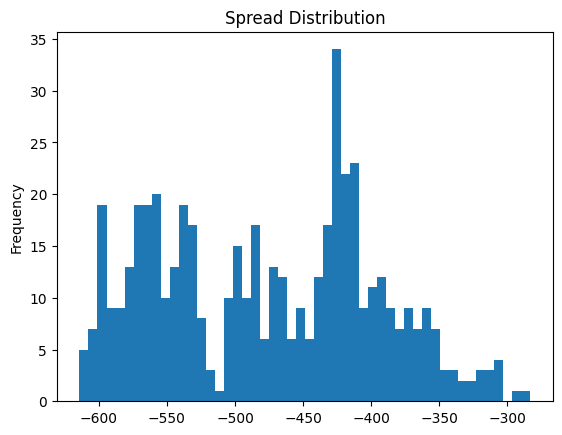

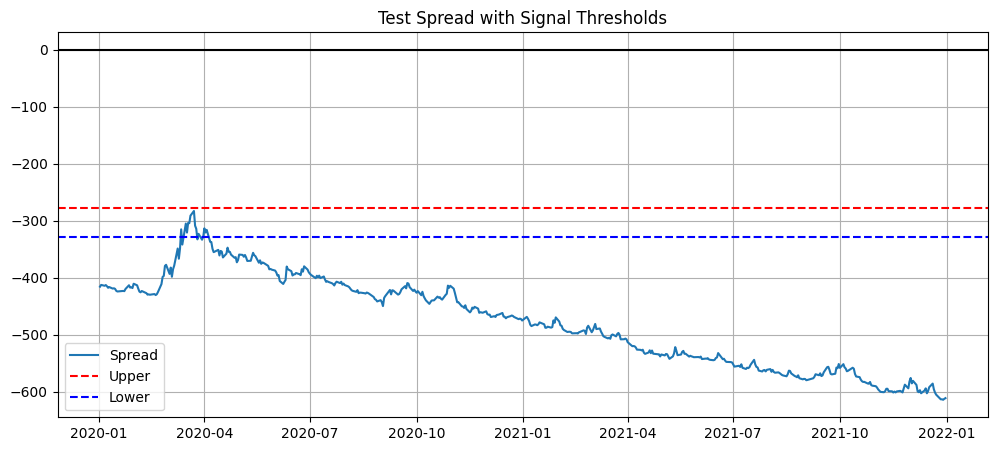

Half-life: 1, Upper: 51.35, Lower: 36.74
 0    251
-1    250
Name: count, dtype: int64


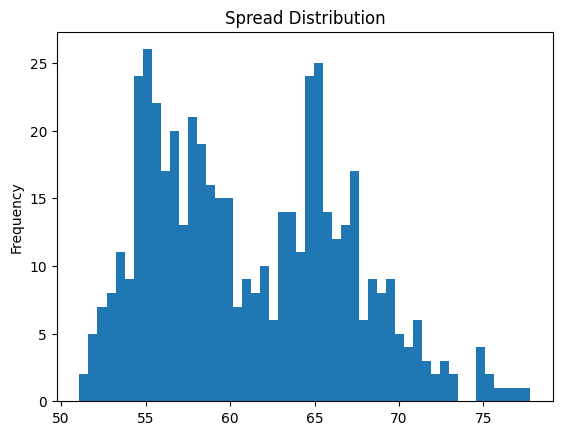

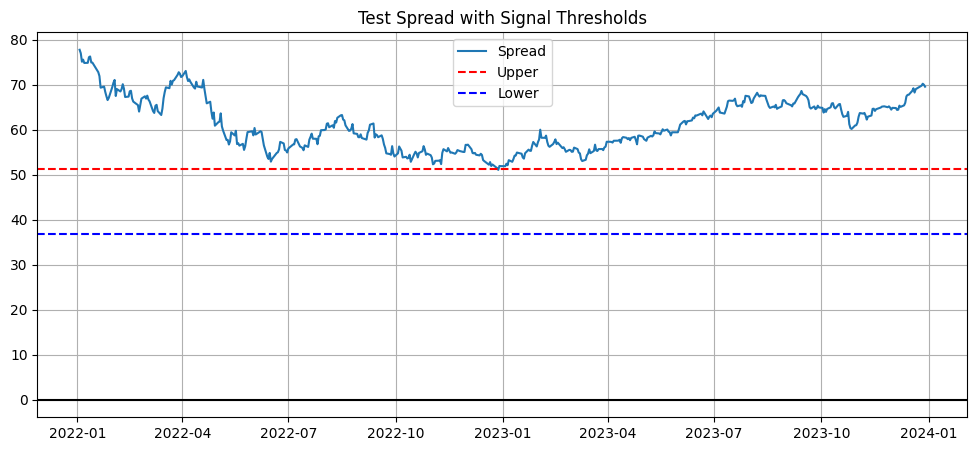

In [76]:
results = process_cointegration_triplet(tickers)

In [54]:
results_df = pd.DataFrame(results)

In [55]:
results_df

,Total Return,CAGR,Ann Vol,Sharpe,Max Drawdown,Trades,Hit Rate,Avg Hold Days,Data Points,train_start,train_end,test_start,test_end
0,-0.316483,-0.316483,0.263610,-1.311451,-0.391884,1,0.392857,363.0,252,2015-01-02,2020-01-01,2020-01-02,2021-01-01
1,-0.000877,-0.000881,0.024454,-0.023857,-0.024667,1,0.474104,360.0,251,2015-01-02,2021-01-01,2021-01-02,2022-01-01
